In [1]:
import os 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


2025-06-07 13:27:32.955802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749302853.200082      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749302853.271054      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


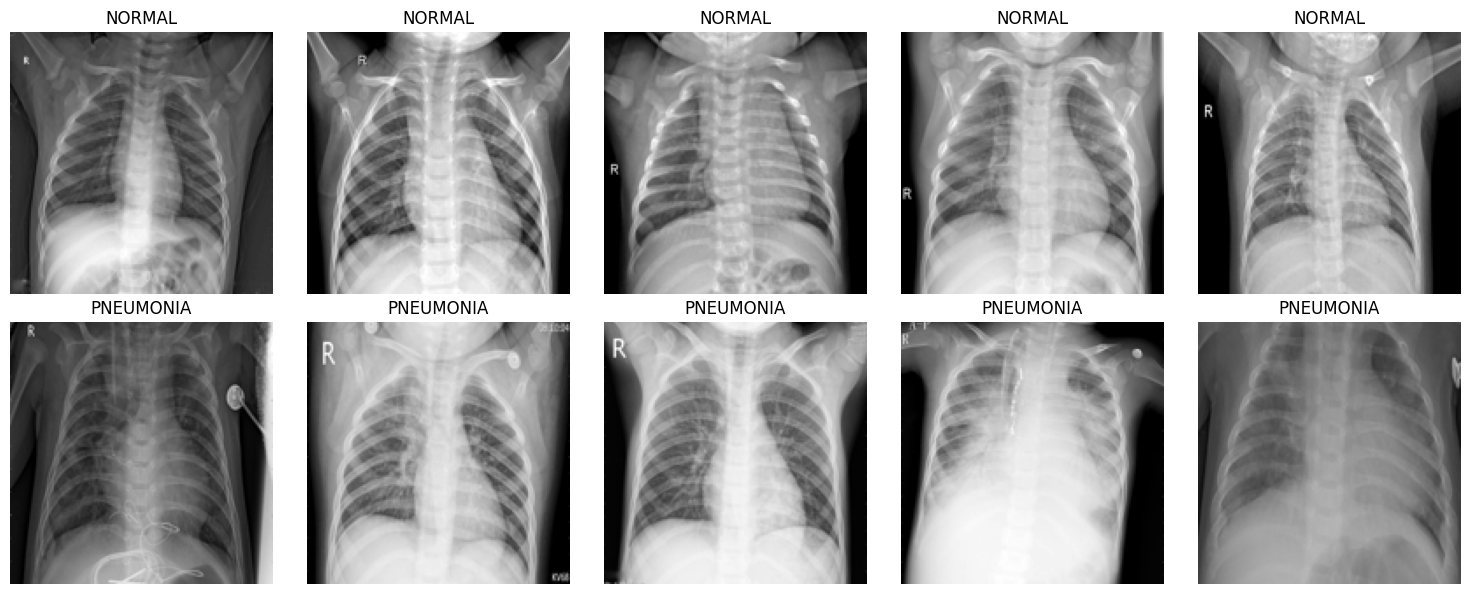

In [2]:
base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
classes = ['NORMAL', 'PNEUMONIA']

sample_images = []

for label in classes:
    folder = os.path.join(base_path, label)
    images = os.listdir(folder)[:5]
    for img in images:
        img_path = os.path.join(folder, img)
        sample_images.append((img_path, label))

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for idx, (img_path, label) in enumerate(sample_images):
    img = Image.open(img_path).resize((150, 150))
    ax = axes[idx // 5, idx % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [3]:
#Preprocess and label Data

def load_sample_dataset(image_label_list, img_size=(150, 150)):
    X, y = [], []
    for img_path, label in image_label_list:
        img = Image.open(img_path).resize(img_size).convert("RGB")
        img = np.array(img) / 255.0
        X.append(img)
        y.append(0 if label == 'NORMAL' else 1)
    return np.array(X), np.array(y)

In [4]:
#Tensorflow model

X_tf, y_tf = load_sample_dataset(sample_images)

model_tf = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_tf.fit(X_tf, y_tf, epochs=3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-07 13:27:58.320394: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 0.7088
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5000 - loss: 15.7851
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5000 - loss: 3.4344


In [5]:
#Pytorch model

X_pt = torch.tensor(X_tf.transpose(0, 3, 1, 2), dtype=torch.float32)
y_pt = torch.tensor(y_tf, dtype=torch.float32).unsqueeze(1)

class CNN_PT(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 74 * 74, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

model_pt = CNN_PT()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

for epoch in range(3):
    optimizer.zero_grad()
    outputs = model_pt(X_pt)
    loss = criterion(outputs, y_pt)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.6935
Epoch 2, Loss: 4.3796
Epoch 3, Loss: 0.9015


In [6]:
def load_full_dataset(base_path, img_size=(150, 150)):
    classes = ["NORMAL", "PNEUMONIA"]
    X, y = [], []
    for label in classes:
        folder = os.path.join(base_path, label)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path).resize(img_size).convert("RGB")
            X.append(np.array(img) / 255.0)
            y.append(0 if label == "NORMAL" else 1)
    return np.array(X), np.array(y)

train_path = "../input/chest-xray-pneumonia/chest_xray/train/"
X_full, y_full = load_full_dataset(train_path)


In [7]:
model_tf = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_tf.fit(X_full, y_full, epochs=5, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - accuracy: 0.6668 - loss: 1.2637 - val_accuracy: 0.9923 - val_loss: 0.0581
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.9131 - loss: 0.3152 - val_accuracy: 0.9885 - val_loss: 0.0391
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 220ms/step - accuracy: 0.9507 - loss: 0.2674 - val_accuracy: 0.9866 - val_loss: 0.0392
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.9569 - loss: 0.2335 - val_accuracy: 0.9847 - val_loss: 0.0418
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.9633 - loss: 0.2172 - val_accuracy: 0.9818 - val_loss: 0.0394


In [8]:
from torch.utils.data import Dataset

class ChestXrayDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [9]:
from torch.utils.data import DataLoader

dataset = ChestXrayDataset(X_full, y_full)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [10]:
model_pt = CNN_PT()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

for epoch in range(5):
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model_pt(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Avg Loss: {epoch_loss / len(dataloader):.4f}")


Epoch 1, Avg Loss: 0.2786
Epoch 2, Avg Loss: 0.1026
Epoch 3, Avg Loss: 0.0647
Epoch 4, Avg Loss: 0.0575
Epoch 5, Avg Loss: 0.0548


In [11]:
def load_test_dataset(base_path, img_size=(150, 150)):
    classes = ["NORMAL", "PNEUMONIA"]
    X, y = [], []
    for label in classes:
        folder = os.path.join(base_path, label)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path).resize(img_size).convert("RGB")
            X.append(np.array(img) / 255.0)
            y.append(0 if label == "NORMAL" else 1)
    return np.array(X), np.array(y)

test_path = "../input/chest-xray-pneumonia/chest_xray/test/"
X_test, y_test = load_test_dataset(test_path)


In [12]:
with torch.no_grad():
    model_pt.eval()
    preds = model_pt(torch.tensor(X_test.transpose(0,3,1,2), dtype=torch.float32))
    acc = ((preds > 0.5).float().squeeze() == torch.tensor(y_test)).float().mean()
    print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.7276


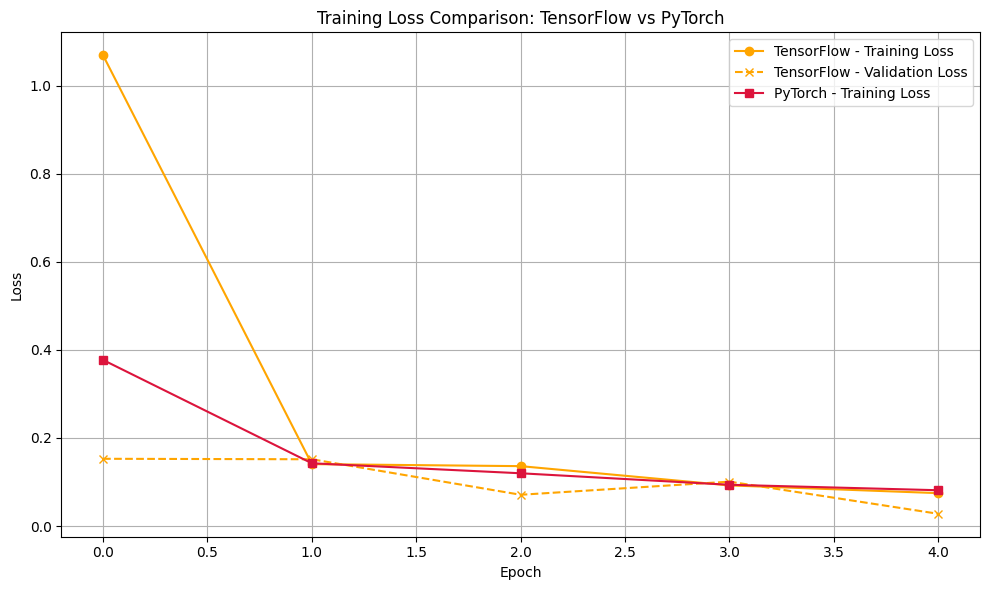

In [13]:
import matplotlib.pyplot as plt

# TensorFlow losses from training (manually noted from logs)
loss_tf = [1.0690, 0.1407, 0.1361, 0.0924, 0.0748]
val_loss_tf = [0.1528, 0.1517, 0.0711, 0.1009, 0.0279]

# PyTorch losses from your output
loss_pt = [0.3772, 0.1426, 0.1199, 0.0938, 0.0814]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(loss_tf, label='TensorFlow - Training Loss', color='orange', marker='o')
plt.plot(val_loss_tf, label='TensorFlow - Validation Loss', color='orange', linestyle='--', marker='x')
plt.plot(loss_pt, label='PyTorch - Training Loss', color='crimson', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: TensorFlow vs PyTorch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [14]:
plt.savefig("loss_comparison.png") 

<Figure size 640x480 with 0 Axes>

In [15]:
model_tf.save("/kaggle/working/chest_xray_tf_model.h5")


In [16]:
torch.save(model_pt.state_dict(), "/kaggle/working/chest_xray_pt_model.pth")
